# KMeans Clustering

This is a helper notebook to test kmeans clustering to create segmentation masks (e.g. test speed, accuracy of kmeans over random init. ResNet50, etc.)

In [1]:
# Imports
import torch
import torch.nn as nn
import torchvision

DEVICE = torch.device("cuda:5")

In [2]:
# Testing FAISS Clustering to see viability (Code from DeepCluster https://github.com/facebookresearch/deepcluster)
import numpy as np
import faiss #Clustering lib
import tqdm.notebook

def get_features(model, dataloader, N, batch_size, model_encode_dim, model_output_shape: tuple):
    model.eval()
    
    spatial_area = model_output_shape[0] * model_output_shape[1]
    features = np.zeros((N * spatial_area, model_encode_dim), dtype='float32') #Memory bank
    pooled_vecs = []
    with torch.no_grad():
        with tqdm.notebook.tqdm(dataloader, unit='instance', total=len(dataloader)) as iterator:
            for i, (img, _) in enumerate(iterator):
                img = img.to(DEVICE)
                output = model(img)
                # output, pooled = model(img)
                # for j in range(pooled.size(0)):
                #     pooled_vecs.append(nn.functional.normalize(pooled[j],dim=0))
                #output = output.permute(0,2,3,1) #(B, 14/7, 14/7, 2048/1024)
                #output = torch.flatten(output, 0, 2).cpu().numpy().astype('float32')
                output = output.cpu().numpy().astype("float32")

                if i < len(dataloader) - 1:
                    features[spatial_area*i * batch_size: spatial_area*(i + 1) * batch_size] = output
                else:
                    # special treatment for final batch
                    features[spatial_area*i * batch_size:] = output
                assert np.array_equal(features[spatial_area*i * batch_size : spatial_area*(i+1)*batch_size], output)

    return features, pooled_vecs

def preprocess_features(npdata, pca=2048):
    """Preprocess an array of features.
    Args:
        npdata (np.array N * ndim): features to preprocess
        pca (int): dim of output
    Returns:
        np.array of dim N * pca: data PCA-reduced, whitened and L2-normalized
    """
    # _, ndim = npdata.shape
    # npdata =  npdata.astype('float32')

    # # Apply PCA-whitening with Faiss
    # mat = faiss.PCAMatrix (ndim, pca, eigen_power=-0.5)
    # mat.train(npdata)
    # assert mat.is_trained
    # npdata = mat.apply_py(npdata)

    # L2 normalization
    row_sums = np.linalg.norm(npdata, axis=1)
    npdata = npdata / row_sums[:, np.newaxis]

    return npdata

def run_kmeans(x, nmb_clusters, pca=256):
    """Runs kmeans on 1 GPU.
    Args:
        x: data
        nmb_clusters (int): number of clusters
    Returns:
        list: ids of data in each cluster
    """
    x = preprocess_features(x)
    n_data, d = x.shape

    # faiss implementation of k-means
    clus = faiss.Clustering(d, nmb_clusters)

    # Change faiss seed at each k-means so that the randomly picked
    # initialization centroids do not correspond to the same feature ids
    # from an epoch to another.
    clus.seed = np.random.randint(1234)

    clus.niter = 20
    clus.max_points_per_centroid = 10000000
    res = faiss.StandardGpuResources()
    flat_config = faiss.GpuIndexFlatConfig()
    flat_config.useFloat16 = False
    flat_config.device = 0
    index = faiss.GpuIndexFlatL2(res, d, flat_config)

    # perform the training
    clus.train(x, index)
    _, I = index.search(x, 1)
    # losses = faiss.vector_to_array(clus.obj)
    # print('k-means loss evolution: {0}'.format(losses))

    return [int(n[0]) for n in I]#, losses[-1]


In [3]:
class ResNetwithProjection(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(*list(torchvision.models.__dict__['resnet50'](pretrained=False).children())[:-2])
        self.projector = nn.Sequential(nn.Linear(2048, 4096), nn.BatchNorm1d(4096), nn.ReLU(), nn.Linear(4096, 256))
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
    
    def forward(self, x):
        encoding = self.encoder(x) #(B, 2048, 7,7)
        encoding = encoding.permute(0, 2,3,1) #(B, 7,7,2048)
        encoding = torch.flatten(encoding, 0, 2)
        assert encoding.shape == (x.size(0)*14**2, 2048)
        encoding = self.projector(encoding)
        #pooled_vector = self.pooling(encoding) # (B, 2048, 1, 1)
        return encoding#, self.projector(torch.flatten(pooled_vector, 1))

In [4]:
# # test_res = nn.Sequential(*list(torchvision.models.__dict__['resnet50'](pretrained=False).children())[:-1]).to(DEVICE)
# test_res = torchvision.models.__dict__['resnet50'](pretrained=False).to(DEVICE)
# transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
#                                             torchvision.transforms.ToTensor(), 
#                                             torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# dataset = torchvision.datasets.ImageFolder('/home/akash/ilsvrc_1p/train/', transform=transform)

In [5]:
# import random
# dp = []
# for _ in range(100):
#     idx1, idx2 = random.randint(0, len(dataset)), random.randint(0, len(dataset))
#     if idx1 == idx2:
#         print("skip")
#         continue
#     img1, img2 = dataset.__getitem__(idx1)[0].unsqueeze(0), dataset.__getitem__(idx2)[0].unsqueeze(0)
#     x1, x2 = test_res(img1.to(DEVICE)), test_res(img2.to(DEVICE))
#     dp.append(nn.CosineSimilarity()(x1, x2).item())
# print(np.mean(dp), np.std(dp))

In [7]:
model = ResNetwithProjection().to(DEVICE)
# Get Imagnet Dataloader
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((448,448)),
                                            torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
dataset = torchvision.datasets.ImageFolder('/home/akash/ilsvrc_1p/train/', transform=transform)
batch_size = 1
N = 1#len(dataset)
dataset = torch.utils.data.Subset(dataset, range(N))
print(f"Using {N} samples!")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=False)

Using 1 samples!


In [8]:
feat_shape = (14,14)
feats, pooled = get_features(model, dataloader, N, batch_size, 256, feat_shape)

  0%|          | 0/1 [00:00<?, ?instance/s]

In [10]:
K = 8
indices = run_kmeans(feats, K)

WARNING clustering 196 points to 8 centroids: please provide at least 312 training points


In [11]:
assert len(indices) == N*(feat_shape[0] * feat_shape[1]), f"got {len(indices)} instead of {N*(feat_shape[0] * feat_shape[1])}"


In [24]:
import matplotlib.pyplot as plt
from skimage import color
from skimage.segmentation import slic
import random
def plot(cluster_indices, img_idx, encoding_size: tuple, use_slic=False):
    spatial_area = encoding_size[0] * encoding_size[1]
    imgs, masks = [], []

    # Get query mask
    dataset = torchvision.datasets.ImageFolder('/home/akash/ilsvrc_1p/train/', transform=torchvision.transforms.Resize((224,224)))

    def get_mask(idx):
        kmeans_seg = np.array([cluster_indices[spatial_area*idx: spatial_area*(idx+1)]]).reshape(encoding_size).astype("float")
        if use_slic:
            kmeans_seg = slic(kmeans_seg, n_segments=K, compactness=0.0010, channel_axis=None).astype("float") #TODO: Check mask arg?
        kmeans_seg = torch.from_numpy(kmeans_seg).unsqueeze(dim=0).unsqueeze(dim=1)
        kmeans_seg = torch.nn.functional.interpolate(kmeans_seg, size=(224, 224)).cpu().numpy()[0,0]
        return kmeans_seg

    if isinstance(img_idx, list):
        if len(img_idx) > 2:
            raise NotImplementedError()
        for img_i in img_idx:
            imgs.append(np.asarray(dataset.__getitem__(img_i)[0]))
            masks.append(get_mask(img_i))
    else:
        img, _ = dataset.__getitem__(img_idx)
        imgs.append(np.asarray(img))
        masks.append(get_mask(img_idx))

    # best_overlap = 0.
    # best_mask = None
    # best_img = None
    # for i in tqdm.notebook.trange(N):
    #     if i != img_idx:
    #         img = dataset.__getitem__(i)[0]
    #         mask = get_mask(i)
    #         overlap = (mask == masks[0]).sum()
    #         if overlap > best_overlap:
    #             best_overlap = overlap
    #             best_mask = mask
    #             best_img = np.asarray(img)
    
    # imgs.append(best_img)
    # masks.append(best_mask)



    #intersection = masks[0] == masks[1]
    slics = [slic(imgs[i], K) for i in range(len(imgs))]
    #slic_intersection = slics[0] == slics[1]
    for i in range(len(imgs)):
        plt.figure()
        f, axarr = plt.subplots(1, 2)
        # f, axarr = plt.subplots(1,2)
        axarr[0].imshow(imgs[i])
        axarr[1].imshow(color.label2rgb(masks[i], imgs[i],bg_label=-1))
        #axarr[2].imshow(color.label2rgb(intersection*masks[i], imgs[i], bg_label=0))
        #axarr[3].imshow(color.label2rgb(slics[i], imgs[i], bg_label=-1))
        #axarr[4].imshow(color.label2rgb(slics[i]*slic_intersection, imgs[i], bg_label=-1))

        axarr[0].axis("off")
        axarr[1].axis("off")
        # axarr[2].axis("off")
        # axarr[3].axis("off")
        # axarr[4].axis("off")

            



<Figure size 432x288 with 0 Axes>

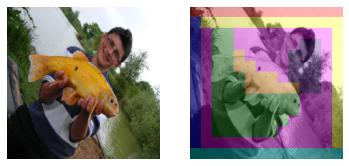

In [25]:
#random.seed(0)
#img_indices = random.sample(list(range(N)), 2)
img_indices=0
plot(indices, img_indices, feat_shape,use_slic=True)

In [428]:
model = ResNetwithProjection().to(DEVICE)
model_path = "/home/akash/detconb/04_07_01-23_resnet50_300.pth.tar" #BYOL (4-07-01-23)
checkpoint = torch.load(model_path, map_location=DEVICE)['model']#['online_backbone']
state_dict = checkpoint
for k in list(state_dict.keys()):
    # retain only encoder_q up to before the embedding layer
    if k.startswith('module.online_network.encoder.'):
        # remove prefix
        new_k = k[len("module.online_network.encoder."):]
        state_dict[new_k] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]
msg = model.encoder.load_state_dict(state_dict, strict=True)
print(msg)

<All keys matched successfully>


In [379]:
feats_pt, pooled_pt = get_features(model, dataloader, N, batch_size, 256, (7,7))
indices_pt = run_kmeans(feats_pt, K)


  0%|          | 0/401 [00:00<?, ?instance/s]

8922
0.9683757424354553 0.03591356059268522


<Figure size 432x288 with 0 Axes>

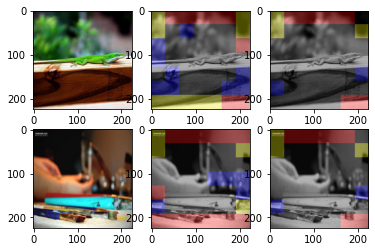

In [400]:
plot(indices_pt, 600, pooled_pt)

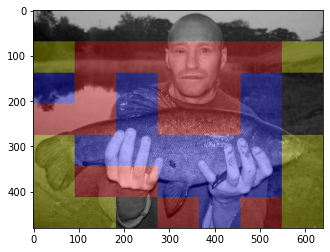

In [165]:
plot(indices_pt, 10)